## Exercise 3: Stereo vision, and triangulation


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation

### Epipolar geometry

Set up two cameras, both with the internal parameters:

$$ K = \begin{bmatrix} 1000 & 0 & 300 \\ 0 & 1000 & 200 \\ 0 & 0 & 1 \end{bmatrix}$$

Now, for the first camera — let us call that `Cam` — set the rotation to identity $R_1 = I$ and set the translation to zero $t_1 = 0$. For the second camera `Cam` use the rotation given by the R function: $R_2= R(0.7,−0.5,0.8)$.


$$ R(\theta_x,\theta_y,\theta_z) = \begin{bmatrix} cos(\theta_z) & -sin(\theta_z) & 0 \\ sin(\theta_z) & cos(\theta_z) & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} cos(\theta_y) & 0 & -sin(\theta_y)\\ 0 & 1 & 0 \\ sin(\theta_y) & 0 & cos(\theta_y) \end{bmatrix} \begin{bmatrix} 1 & 0 & 0\\ 0 & cos(\theta_x) & -sin(\theta_x) \\ 0 & sin(\theta_x) & cos(\theta_x) \end{bmatrix}$$

and the translation:
$$ t_2 = \begin{bmatrix} 0.2 \\ 2 \\ 1 \end{bmatrix}$$



- **Exercise 3.1**. Consider the 3D point:
$$ Q = \begin{bmatrix} 1 \\ 0.5 \\ 4 \\ 1 \end{bmatrix}$$
and find the projections in `Cam` and `Cam2` respectively, points $q_1$ and $q_2$.


In [3]:
K=np.array([[1000,0,300],[0,1000,200],[0,0,1]])

R1=np.eye(3)
t1=np.zeros((3,1))
Cam1=np.column_stack((R1,t1))

R2=Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2=np.array([[0.2],[2],[1]])
Cam2=np.column_stack((R2,t2))

Q=[1,0.5,4,1]


In [4]:
def projectpoints(K,Cam,Q):
    #projection matrix P
    P=K@Cam
    
    Q_ext=np.transpose(Q)
    projection=P@Q_ext
    
    qx=np.transpose([projection[0]/projection[2]])
    qy=np.transpose([projection[1]/projection[2]])
    
    project2D=np.column_stack((qx,qy))
    
    project3D=np.transpose(projection)
    
    return project2D,project3D

In [5]:
p1,p1_3D=projectpoints(K,Cam1,Q)
print('The projection of point Q in first camera is p1=',p1[0])

p2,p2_3D=projectpoints(K,Cam2,Q)
print('The projection of point Q in first camera is p2=',p2[0])

The projection of point Q in first camera is p1= [550. 325.]
The projection of point Q in first camera is p2= [582.47256835 185.98985776]


- **Exercise 3.2**. Implement a function `CrossOp` that takes a vector in 3D and returns the 3×3 matrix corresponding to taking the cross product with that vector. In the case that $p = [x  y  z]^T$ you should have:

$$ CrossOp(p) = [p]_x = \begin{bmatrix} 0 & -z & y \\ z & 0 & -x \\ -y & x & 0  \end{bmatrix}$$

As a good habit, verify that your function works by testing it on random vectors to ensure that:
$$ [p_1]_x p_2 = p_1 x p_2 $$



In [6]:
def CrossOp(p):
    x,y,z=p[0],p[1],p[2]
    cross=np.array([[0,-z,y],[z, 0,-x],[-y,x,0]])
    return cross

- **Exercise 3.3**. Compute the **fundamental matrix F** of the two cameras.



In [8]:
def compute_Fmat_Emat(t,R,K1,K2):
    #K1, K2 instrincisc properties of each camera. 
    
    t_cross=CrossOp(t[:,0])
    E=t_cross@R #essential matrix

    F=np.linalg.inv(K2).T@E@np.linalg.inv(K1)
    return E, F

In [9]:
E,F= compute_Fmat_Emat(t2,R2,K,K)
print('E =')
print(np.round(E,2))
print("")
print('F =')
print(np.round(F,3))


E =
[[ 0.33  0.82  2.05]
 [ 0.52 -0.88  0.07]
 [-1.1   1.59 -0.56]]

F =
[[ 0.000e+00  0.000e+00  2.000e-03]
 [ 0.000e+00 -0.000e+00  0.000e+00]
 [-1.000e-03  2.000e-03 -1.101e+00]]


- **Exercise 3.4**. What is the epipolar line _l_ of _$q_1$_ in camera two?

<font color='darkblue'> We can compute the epipolar lines l = Fp from just the Fundamental matrix and the corresponding points.

In [10]:
print(p1_3D)
l= F@p1_3D

print('The epipilar line l of q_1 in camera 2 is:',l)


[2200. 1300.    4.]
The epipilar line l of q_1 in camera 2 is: [ 8.95620504e-03  3.66751496e-04 -5.28495581e+00]


- **Exercise 3.5**. Is $q_2$ located on the epipolar line from Ex. 3.4? Do the computations, but also explain why this must be so.

<font color='darkblue'> To see if a point _q_ is on a line we can use that $q^T l = 0$. 

In [11]:
p_on_l=p2_3D.T@l
print('The result of q2l is:',p_on_l)
print('Takinh numerical precision into account, the approximation is',round(p_on_l),'.')
print('Then, the point is on the line.')

The result of q2l is: 7.105427357601002e-15
Takinh numerical precision into account, the approximation is 0 .
Then, the point is on the line.


<font color='darkblue'> This must be true, since both the point $q_2$ and the line $l$ are derived from the same 3D point $Q$. This 3D point yields a single epipolar plane, and the plane yields a single line in each camera. The projections of the 3D point must lie on the epipolar lines.

- **Exercise 3.6**. Now assume that both camera one and two have local coordinate systems that are different from the coordinate system of the world.

Let $Q$ and $Q'$ denote the same 3D point in world space and in the frame of camera one. In other words we have relation:

$$ Q' = \begin{bmatrix} R_1 & t_1 \\ 0 & 1 \end{bmatrix} Q $$

Make sure you understand why this is true. Show analytically that
$$ Q = \begin{bmatrix} R_1^T & -R_1^T t_1 \\ 0 & 1 \end{bmatrix} Q' $$

<font color='darkblue'> 
    
$$ Q' = \begin{bmatrix} R_1 & t_1 \\ 0 & 1 \end{bmatrix}  \begin{bmatrix} R_1^T & -R_1^T t_1 \\ 0 & 1 \end{bmatrix} Q'$$
    
    
$$ Q' = \begin{bmatrix} R_1 R_1^T & -R_1R_1^T+t_1 \\ 0 & 1 \end{bmatrix}Q'$$
    
$$ Q' = \begin{bmatrix} I & 0 \\ 0 & 1 \end{bmatrix}Q'$$
    
And we find that it is valid! This is true as the matrices are inverses of each other.


<font color='darkblue'> 
    

- **Exercise 3.7**. Show that the can work only in the coordinate system of camera one, by showing that we can project points with


$$ q_1 = K \begin{bmatrix} I & 0 \end{bmatrix} Q' ,   q_2 = K \begin{bmatrix} R_2' & t_2' \end{bmatrix} Q'$$

where

$$ R_2' = R_2 R_1^T, t_2'= t_2 - R_2 R_1^T t_1$$

<font color='darkblue'> For the first projection in camera one we reduce the projection equation: 

<font color='darkblue'>
$$ q_1 = K\begin{bmatrix} R_1| & t_1 \end{bmatrix} Q, $$ 
$$ = K \begin{bmatrix} I & 0 \end{bmatrix} \begin{bmatrix} R_1 & t_1\\ 0 & 1 \end{bmatrix}Q , $$
    
$$ = K \begin{bmatrix} I & 0 \end{bmatrix} Q' , $$

    
<font color='darkblue'> For the second projection into camera two we insert: 

<font color='darkblue'>
$$ q_2 = K\begin{bmatrix} R_2|& t_2 \end{bmatrix} Q, $$ 
$$ q_2 = K \begin{bmatrix} R_2|& t_2 \end{bmatrix} \begin{bmatrix} R_1 & t_1\\ 0 & 1 \end{bmatrix} Q' , $$
$$ q_2 = K \begin{bmatrix} R_2 R_1^T & t_2-R_2't_1 \end{bmatrix} Q' , $$
$$ q_2 = K \begin{bmatrix} R_2' & t_2' \end{bmatrix} Q' . $$
    
where $$ R_2'= R_2R_1^T , t_2' = t_2 - R_2't_1  $$ 

### Applied Epipolar geometry



- **Exercise 3.8**. Load the file TwoImageData.npy, and compute the fundamental matrix between camera one and two.

In [12]:
data= np.load('TwoImageData.npy', allow_pickle=True).item()
print('R1 is the identity matrix and t1 is 0.')
t22=data['t2']
R22=data['R2']
KK=data['K']
E,F= compute_Fmat_Emat(t22,R22,KK,KK)
print(" ")
print('F =')
print(np.round(F,8))


R1 is the identity matrix and t1 is 0.
 
F =
[[ 0.000e+00 -0.000e+00  1.200e-07]
 [-0.000e+00 -0.000e+00  3.287e-05]
 [ 4.200e-07 -3.217e-05 -2.120e-04]]


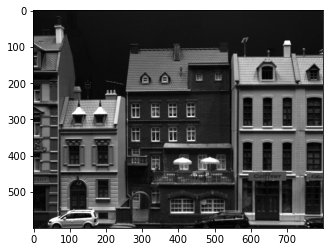

In [13]:
#Loading images
img1=data['im1']
img2=data['im2']

plt.imshow(img1,cmap='gray')


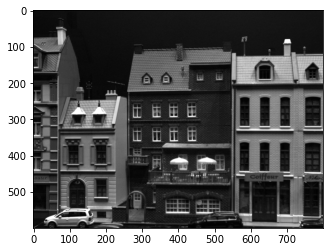

In [14]:
plt.imshow(img2,cmap='gray')


- **Exercise 3.9**. Write code that can show both images at the same time. Now write code such that you can click on a point in image one, and display the corresponding epipolar line in image two. Experiment with your code, verifying that the point you click on is on the epipolar line in the other image.

To click on a point and get the pixel coordinates you can use `plt.ginput(1)`.
To draw a line given in homogeneous coordinates, you can use the `DrawLine` function below. It takes as input a line in homogeneous coordinates l and the size of the image it will be drawn on, as returned by im.shape.

In [15]:
#Loading images
img1=data['im1']
img2=data['im2']

# concatanate image Horizontally
Hori = np.concatenate((img1, img2), axis=1)
shape_img=Hori.shape

#cv2.imshow('HORIZONTAL', Hori)
# wait for a key to be pressed to exit
#cv2.waitKey(0)

# close the window
#cv2.destroyAllWindows()


#To click on a point and get the pixel coordinates
#plt.imshow(Hori)
#x = plt.ginput(1) 
#print(x)
#plt.show()



#Compute the epipolar line in image two
#epi_l= F@p



In [16]:
p=[293 , 155,1]
epi_l= F@p
print(epi_l)

[-1.80361247e-09  3.25832155e-05 -5.07432803e-03]


In [ ]:
def DrawLine(l, shape,Hori):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
        
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    plt.plot(*np.array(P).T)
    plt.imshow(img2,cmap='gray')
    plt.axis('off')

In [ ]:
display= DrawLine(epi_l, shape_img,Hori)

- **Exercise 3.10**. Do the same thing as the last exercise, but where you can click in image two and get the epipolar line displayed in image one.



### Programming exercise: Triangulation

- **Exercise 3.11**. Create a function `triangulate` that takes a list of pixel coordinates (q1, q2, . . . , qn), and a list of projection matrices (P1, P2, . . . , Pn), and the function returns the triangulation of the point using the linear algorithm.


Test your function by defining some 3D points — use the box3D function, for example — project them to the image planes of the two cameras, and then re-triangulate them back to the original coordinates.

You can similarly use a number of corresponding pixel coordinates, triangulate them, and then re-project the 3D points into the cameras. Do you find the same 2D pixels? If not, why?


In [17]:
def box3d(n):
    comb=[(0.5,0.5),(0.5,-0.5),(-0.5,0.5),(-0.5,-0.5)]
    a=np.linspace(-0.5, 0.5, n)
    box=[0,0,0]

    for j in comb:
        for i in a:
            p=[i,j[0],j[1]]
            box=np.vstack([box, p])

    for j in comb:
        for i in a[1:-1]:
            p=[j[0],i,j[1]]
            box=np.vstack([box, p])

    for j in comb:
        for i in a[1:-1]:
            p=[j[0],j[1],i]
            box=np.vstack([box, p])

    for i in a:
        cross1=[i,0,0]   
        box=np.vstack([box, cross1])
    for i in a:
        cross2=[0,i,0]   
        box=np.vstack([box, cross2])
    for i in a:
        cross3=[0,0,i]   
        box=np.vstack([box, cross3])
      
    box=box[1:]
    

    return box

In [18]:
coord=box3d(16)
[m,n]=np.shape(coord)
cnt=np.ones(m)
Q_ext=np.column_stack((coord,cnt)).T

K=data['K']
t1=data['t1']
R1=data['R1']
t2=data['t2']
R1=data['R2']
Cam11=np.column_stack((R1,t1))
Cam22=np.column_stack((R2,t2))
P1=K@Cam11
P2=K@Cam22

#We project the 3D points to the image planes of the two cameras
projection1=(P1@Q_ext).T
projection2=(P2@Q_ext).T

#Then, we re-triangulate them back to the original coordinates.
#pixel_coord=[projection1,projection2]
#proj_mat=[P1,P2]
#tri_Q= triangulate(pixel_coord, proj_mat)

In [19]:
P1=K@Cam1
P2=K@Cam2
projection1=(P1@Q_ext).T
projection2=(P2@Q_ext).T

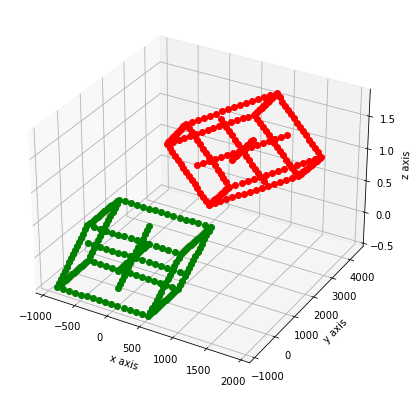

In [20]:
# Create a figure, and specify the size  
fig = plt.figure(figsize=(15,15))
# Create axes 
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for point in projection1:
    ax.plot(point[0], point[1], point[2], 'go')

for point in projection2:
    ax.plot(point[0], point[1], point[2], 'ro')

In [76]:
def matrix_B_tirnagulation(q, P):
    """
    Creates  B matrix for Triangulation. Follows the next equation:
        qh = P*Q
    Where qh is a 2D point in homoogenous form [sx, sy, s], P is the Projection Matrix and Q it's a 3D point in homogenous
    coordinates [X, Y, Z, 1].
    We can rearange it as:
        s * [x, y].T = [p(1)*Q, p(2)*Q].T
    Where p(i) = row vector of P. P(1) = P[0,:] (1,3) and the scale s = p(3)*Q:
        0 = [p(3)*x-p(1), p(3)*y-p(2)].T*Q
    
    PARAMETERS
    q: Point in homogenous fom [sx, sy, s] -> (3,1)
    P: projection matrix K*[R t] -> (3,4)
    RETURNS
    B: B Matrix (2,4)
    """
    #  Extract parameters
    if q[2]==0:
        x = q[0]
        y = q[1]
     
    else:
        x = q[0]/q[2]
        y = q[1]/q[2]
        
    p_1 = P[0,:]
    p_2 = P[1,:]
    p_3 = P[2,:]
    
    # Create B
    B = np.array([(p_3*x - p_1), (p_3*y-p_2)])
    
    return B

In [77]:
def triangulate(qs:list, P:list):
    """
    Find points in 3D given a set of points in 2D and the Cameras' Projection Matrices used to obtain those 2D points.
    Using Linear algorithm.
    Create a Matrix B fof (n*2,4) where n is the number of cameras. Check Triabngulate_B for further doc.
    One We have B we apply singular value decomposition.
        arg min||B*Q||_2
    Wehere we impose the constrain of:
        ||Q||_2 = 1
    To specify that Q hasn't to be 0.
    
    PARAMETERS
    qs: List of points in 2D points in homogenous from. Scale Matters. 
    P: List of Projection Matrix.
    
    RETURNS
    Q: Estimated point in 3D in Homogenous coordinates [X, Y, Z, 1]
    """
    
    # Check The same samount of points and cameras.
    if len(qs) != len(P):
        print('Different number of 2D points and Projection matrix.')
        return False
    
    # Get the number of cameras
    n = len(P)
    # Set step for the B matrix 
    step = 2

    # Initializate B
    B = np.zeros((step*n, 4))
    
    for p,q,i in zip(P,qs, range(0,n*step,step)):
        B[i:i+step] = matrix_B_tirnagulation(q,p)

    _,s,eigVec = np.linalg.svd(B)
    # Find Min 
    idx = np.where(s==min(s))
    # Select the eigenvector correspondent to the eigenvalue
    Q = eigVec[idx]
    
    return  Q


In [78]:
all_3D=[]
for a in range(len(projection1)):
    pixel_coord=[projection1[a,:],projection2[a,:]]
    P_mat=[P1,P2]
    
    Q_3D=triangulate(pixel_coord, P_mat)
    Q_3D=Q_3D/Q_3D[-1][-1] 
    
    all_3D.append(Q_3D)



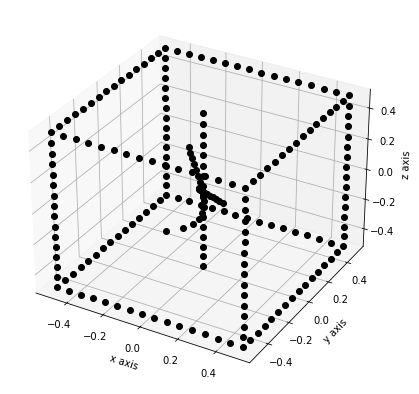

In [95]:
# Create a figure, and specify the size  
fig = plt.figure(figsize=(15,15))
# Create axes 
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for point in all_3D:
    ax.plot(point[0][0], point[0][1], point[0][2], 'ko')